In [1]:
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from scipy.stats import linregress
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

# Scraping data from three sources and simple cleaning

In [2]:
master_list = [] 

for year in range(2013, 2023):
    s_path = f'../data/raw/season/{year}_season_stats.csv'
    URL = f'https://www.pro-football-reference.com/years/{year}/fantasy.htm'
    res = requests.get(URL)
    
    soup = bs(res.content, 'html5lib')
    table = soup.find('table', {'id': 'fantasy'})
    df = pd.read_html(str(table))[0]
    df.columns = df.columns.droplevel(level=0)

    df = df.loc[df['Player'] != 'Player'] #removing filler rows
    df['Player'] = df['Player'].apply(lambda x: x.split('*')[0].strip()) #fixing player names that have astericks

    df['PassingYds'] = df['Yds'].iloc[:,0]
    df['RushingYds'] = df['Yds'].iloc[:,1]
    df['ReceivingYds'] = df['Yds'].iloc[:,2]

    df['PassingTD'] = df['TD'].iloc[:,0]
    df['RushingTD'] = df['TD'].iloc[:,1]
    df['ReceivingTD'] = df['TD'].iloc[:,2]

    df['PassingAtt'] = df['Att'].iloc[:,0]
    df['RushingAtt'] = df['Att'].iloc[:,1]

    df['Season'] = year

    df = df.rename(columns={
        'FantPos': 'Pos', 'FantPt': 'FantasyPoints', 'Fmb': 'Fumbles', 'FL': 'FumblesLost'
    })

    df = df[[
        'Player','Season','Tm','Pos','Age','G','GS','Tgt','Rec','PassingYds','PassingTD','PassingAtt',
        'RushingYds','RushingTD','RushingAtt','ReceivingYds','ReceivingTD','FantasyPoints',
        'Int','Fumbles','FumblesLost'
    ]]

    # uncomment code below to save fantasy stats table for each page to a csv
    # df.to_csv(s_path.format(year=year),index=False)

    master_list.append(df)

master_df = pd.concat(master_list, ignore_index=False)
master_df

# uncomment code below to save all tables to one csv
# master_df.to_csv('../data/raw/season/master_season_stats.csv', index=False)

,Player,Season,Tm,Pos,Age,G,GS,Tgt,Rec,PassingYds,PassingTD,PassingAtt,RushingYds,RushingTD,RushingAtt,ReceivingYds,ReceivingTD,FantasyPoints,Int,Fumbles,FumblesLost
0,Jamaal Charles,2013,KAN,RB,27,15,15,104,70,0,0,0,1287,12,259,693,7,308,0,4,2
1,LeSean McCoy,2013,PHI,RB,25,16,16,64,52,0,0,0,1607,9,314,539,2,279,0,1,1
2,Peyton Manning,2013,DEN,QB,37,16,16,0,0,5477,55,659,-31,1,32,0,0,410,10,10,6
3,Matt Forte,2013,CHI,RB,28,16,16,95,74,0,0,0,1339,9,289,594,3,263,0,2,2
4,Jimmy Graham,2013,NOR,TE,27,16,12,142,86,0,0,0,0,0,0,1215,16,218,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
666,Ihmir Smith-Marsette,2022,2TM,WR,23,8,0,4,1,0,0,0,-1,0,1,15,0,-1,0,1,1
667,KaVontae Turpin,2022,DAL,WR,26,17,0,2,1,0,0,0,17,0,3,9,0,-1,0,3,2
668,Taiwan Jones,2022,BUF,NaN,34,16,0,0,0,0,0,0,0,0,0,0,0,-2,0,1,1
669,Chester Rogers,2022,CLE,NaN,28,3,0,0,0,0,0,0,0,0,0,0,0,-2,0,1,1


In [3]:
def name_splitter(name):
    """
    Input:
        name - obj input of scraped df.Player column
    Output:
        Returns a string output in the format of "first_name last_name"
    """
    name_str = re.split(r",", re.sub(r"\b[A-Z]{2,3}\s[A-Z]{2}\b",'',name))
    f_output = name_str[1].lstrip() + name_str[0]
    return f_output

master_adp_list = [] 

for year in range(2013,2023):
    s_path = f'../data/raw/adp/{year}_adp.csv'
    URL = f'https://www46.myfantasyleague.com/{year}/reports?R=ADP&POS=*&PERIOD=AUG15&CUTOFF=5&FCOUNT=12&ROOKIES=0&INJURED=0&IS_PPR=2&IS_KEEPER=[NKR]&IS_MOCK=1&PAGE=ALL'
    res = requests.get(URL)
    soup = bs(res.content, 'html5lib')
    table = soup.find('table', {'class':'report'})
    df = pd.read_html(str(table))[0]
    df = df.iloc[:-1,:]
    df['Pos'] = df['Player'].apply(lambda x: x.split()[-1])
    df['Tm'] = df['Player'].apply(lambda x: x.split()[-2])
    df['Player'] = np.where(df['Pos'] != 'Def', df['Player'].apply(name_splitter), df['Player'])
    df['Season'] = year
    df = df.drop(columns=[
        'Min Pick',
        'Max Pick',
        '% Selected'
    ])

    # uncomment code below to save adp for each year
    # df.to_csv(s_path.format(year=year),index=False)
    master_adp_list.append(df)

master_adp_df = pd.concat(master_adp_list,ignore_index=False)

# uncomment code below to save all adp tables to one csv
# master_adp_df.to_csv('../data/raw/adp/master_adp.csv', index=False)

In [4]:
URL = f'https://www46.myfantasyleague.com/2023/reports?R=ADP&POS=*&PERIOD=AUG15&CUTOFF=5&FCOUNT=12&ROOKIES=0&INJURED=0&IS_PPR=2&IS_KEEPER=[NKR]&IS_MOCK=1&PAGE=ALL'
res = requests.get(URL)
soup = bs(res.content, 'html5lib')
table = soup.find('table', {'class':'report'})
adp_2023_df = pd.read_html(str(table))[0]
adp_2023_df = adp_2023_df.iloc[:-1,:]
adp_2023_df['Pos'] = adp_2023_df['Player'].apply(lambda x: x.split()[-1])
adp_2023_df['Tm'] = adp_2023_df['Player'].apply(lambda x: x.split()[-2])
adp_2023_df['Player'] = np.where(adp_2023_df['Pos'] != 'Def', adp_2023_df['Player'].apply(name_splitter), adp_2023_df['Player'])
adp_2023_df['Season'] = 2023
adp_2023_df = adp_2023_df.drop(columns=[
    'Status',
    'Min Pick',
    'Max Pick',
    '% Selected'
])
adp_2023_df

#uncomment code below to save as csv
# adp_2023_df.to_csv('../data/raw/adp/2023_adp.csv',index=False)

,Rank,Player,Avg Pick,Pos,Tm,Season
0,1,Justin Jefferson,2.55,WR,MIN,2023
1,2,Christian McCaffrey,3.79,RB,SFO,2023
2,3,Ja'Marr Chase,4.47,WR,CIN,2023
3,4,Austin Ekeler,5.71,RB,LAC,2023
4,5,Tyreek Hill,7.33,WR,MIA,2023
...,...,...,...,...,...,...
355,356,Detroit DET TMPKLions,190.61,TMPK,DET,2023
356,357,Seattle SEA TMPKSeahawks,190.75,TMPK,SEA,2023
357,358,Cade Otton,191.88,TE,TBB,2023
358,359,Mack Hollins,191.95,WR,ATL,2023


In [5]:
URL = "https://www.drafthistory.com/positions/wr.html"
res = requests.get(URL)
soup = bs(res.content, 'html5lib')
table = soup.find('table')
wr_draft_all_df = pd.read_html(str(table))[0]
wr_draft_all_df = wr_draft_all_df.iloc[1:,:]
wr_draft_all_df = wr_draft_all_df.rename(columns=wr_draft_all_df.iloc[0]).drop(wr_draft_all_df.index[0]).reset_index(drop=True)
wr_draft_all_df = wr_draft_all_df.fillna(method='ffill')

# uncomment code below to save draft years of all wide receivers in NFL history
# wr_draft_all_df.to_csv('../data/raw/draft/wr_draft_year_all.csv',index=False)

## Cleaning, pre-processing, and feature-engineering of raw data files

In [6]:
wr_draft_all_df = pd.read_csv('../data/raw/draft/wr_draft_year_all.csv')
wr_draft_all_df = wr_draft_all_df.drop(columns=['Player','Team'])
wr_draft_all_df['Pos'] = 'WR'
wr_draft_all_df.rename(columns={'Year':'rookie_season','Name':'Player'}, inplace=True)

# uncomment code below to save processed data
# wr_draft_all_df.to_csv('../data/processed/draft/wr_draft_year_all.csv',index=False)

In [7]:
master_season_stats_df = pd.read_csv('../data/raw/season/master_season_stats.csv')
# calculating fantasy points with the points per reception (PPR) scoring method for each entry
master_season_stats_df['PPR'] = (master_season_stats_df['RushingYds'] + master_season_stats_df['ReceivingYds'])*0.1 + master_season_stats_df['PassingYds']*0.04 + (master_season_stats_df['RushingTD'] + master_season_stats_df['ReceivingTD'])*6 \
    + master_season_stats_df['PassingTD']*4 + master_season_stats_df['Rec'] + master_season_stats_df['FumblesLost']*-2 + master_season_stats_df['Int']*-2 
# fix team names so they match for all data
master_season_stats_df.replace({'Tm':{
    'KAN':'KCC',
    'NOR':'NOS',
    'GNB':'GBP',
    'SDG':'LAC',
    'TAM':'TBB',
    'JAX':'JAC',
    'NWE':'NEP',
    'OAK':'LVR',
    'STL':'LAR'
    
}},inplace=True)

# uncomment code below to save processed season stats data master df
# master_season_stats_df.to_csv('../data/processed/season/master_season_stats.csv', index=False)
master_season_stats_df

,Player,Season,Tm,Pos,Age,G,GS,Tgt,Rec,PassingYds,PassingTD,PassingAtt,RushingYds,RushingTD,RushingAtt,ReceivingYds,ReceivingTD,FantasyPoints,Int,Fumbles,FumblesLost,PPR
0,Jamaal Charles,2013,KCC,RB,27,15,15,104.0,70.0,0.0,0.0,0.0,1287.0,12.0,259.0,693.0,7.0,308.0,0.0,4.0,2.0,378.00
1,LeSean McCoy,2013,PHI,RB,25,16,16,64.0,52.0,0.0,0.0,0.0,1607.0,9.0,314.0,539.0,2.0,279.0,0.0,1.0,1.0,330.60
2,Peyton Manning,2013,DEN,QB,37,16,16,0.0,0.0,5477.0,55.0,659.0,-31.0,1.0,32.0,0.0,0.0,410.0,10.0,10.0,6.0,409.98
3,Matt Forte,2013,CHI,RB,28,16,16,95.0,74.0,0.0,0.0,0.0,1339.0,9.0,289.0,594.0,3.0,263.0,0.0,2.0,2.0,335.30
4,Jimmy Graham,2013,NOS,TE,27,16,12,142.0,86.0,0.0,0.0,0.0,0.0,0.0,0.0,1215.0,16.0,218.0,0.0,0.0,0.0,303.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6146,Ihmir Smith-Marsette,2022,2TM,WR,23,8,0,4.0,1.0,0.0,0.0,0.0,-1.0,0.0,1.0,15.0,0.0,-1.0,0.0,1.0,1.0,0.40
6147,KaVontae Turpin,2022,DAL,WR,26,17,0,2.0,1.0,0.0,0.0,0.0,17.0,0.0,3.0,9.0,0.0,-1.0,0.0,3.0,2.0,-0.40
6148,Taiwan Jones,2022,BUF,NaN,34,16,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.0,0.0,1.0,1.0,-2.00
6149,Chester Rogers,2022,CLE,NaN,28,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.0,0.0,1.0,1.0,-2.00


In [8]:
adp_master_df = pd.read_csv('../data/raw/adp/master_adp.csv')
# fix team names so they match for all data
adp_master_df.replace({'Tm':{
    'SDC':'LAC',
    'OAK':'LVR',
    'STL':'LAR',
    'RAM':'LAR'
    
}},inplace=True)

# uncomment code below to save processed adp data master df 
# adp_master_df.to_csv('../data/processed/adp/master_adp_processed.csv', index=False)
adp_master_df

,Rank,Player,Avg Pick,Pos,Tm,Season
0,1,Adrian Peterson,5.05,RB,MIN,2013
1,2,Doug Martin,7.42,RB,TBB,2013
2,3,Arian Foster,8.17,RB,HOU,2013
3,4,Calvin Johnson,8.60,WR,DET,2013
4,5,Jamaal Charles,9.47,RB,KCC,2013
...,...,...,...,...,...,...
3825,348,Nick Westbrook-Ikhine,193.69,WR,TEN,2022
3826,349,Zay Jones,193.93,WR,JAC,2022
3827,350,Damien Williams,194.72,RB,FA,2022
3828,351,Chris Evans,194.75,RB,CIN,2022


In [9]:
analysis_df = master_season_stats_df.merge(adp_master_df, how='inner', on=['Player','Pos','Tm','Season'])
analysis_df.drop(columns=['FantasyPoints'],inplace=True)
wr_draft_all_df['rookie_season'] = pd.to_numeric(wr_draft_all_df['rookie_season'], errors='coerce')

wr_draft_1999_df = wr_draft_all_df.loc[wr_draft_all_df.rookie_season > 1999,:]
wr_analysis_df = analysis_df.merge(wr_draft_1999_df, how = 'inner', on = ['Player','Pos'])
wr_analysis_df['current_yr'] = wr_analysis_df.Season - wr_analysis_df.rookie_season + 1.0
wr_analysis_df['FPPG'] = wr_analysis_df['PPR']/wr_analysis_df['G']
wr_analysis_df

# uncomment below to save df for analysis 
# wr_analysis_df.to_csv('../data/analysis_df/wr_analysis.csv',index=False)

,Player,Season,Tm,Pos,Age,G,GS,Tgt,Rec,PassingYds,PassingTD,PassingAtt,RushingYds,RushingTD,RushingAtt,ReceivingYds,ReceivingTD,Int,Fumbles,FumblesLost,PPR,Rank,Avg Pick,rookie_season,No.,Round,Pick,College,current_yr,FPPG
0,Demaryius Thomas,2013,DEN,WR,26,16,16,142.0,92.0,0.0,0.0,0.0,0.0,0.0,0.0,1430.0,14.0,0.0,1.0,0.0,319.0,22,25.49,2010.0,1,1,22,Georgia Tech,4.0,19.937500
1,Demaryius Thomas,2014,DEN,WR,27,16,16,184.0,111.0,0.0,0.0,0.0,0.0,0.0,0.0,1619.0,11.0,0.0,0.0,0.0,338.9,7,11.47,2010.0,1,1,22,Georgia Tech,5.0,21.181250
2,Demaryius Thomas,2015,DEN,WR,28,16,16,177.0,105.0,0.0,0.0,0.0,0.0,0.0,0.0,1304.0,6.0,0.0,2.0,2.0,267.4,9,15.58,2010.0,1,1,22,Georgia Tech,6.0,16.712500
3,Demaryius Thomas,2016,DEN,WR,29,16,16,144.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0,1083.0,5.0,0.0,2.0,2.0,224.3,29,31.30,2010.0,1,1,22,Georgia Tech,7.0,14.018750
4,Demaryius Thomas,2017,DEN,WR,30,16,16,140.0,83.0,0.0,0.0,0.0,0.0,0.0,0.0,949.0,5.0,0.0,1.0,1.0,205.9,31,32.47,2010.0,1,1,22,Georgia Tech,8.0,12.868750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
813,Skyy Moore,2022,KCC,WR,22,16,3,33.0,22.0,0.0,0.0,0.0,24.0,0.0,3.0,250.0,0.0,0.0,3.0,3.0,43.4,145,116.34,2022.0,13,2,22,Western Michigan,1.0,2.712500
814,Jameson Williams,2022,DET,WR,21,6,0,9.0,1.0,0.0,0.0,0.0,40.0,0.0,1.0,41.0,1.0,0.0,0.0,0.0,15.1,204,137.50,2022.0,4,1,12,Alabama,1.0,2.516667
815,Kyle Philips,2022,TEN,WR,23,4,0,13.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,78.0,0.0,0.0,2.0,2.0,11.8,172,127.68,2022.0,23,5,20,UCLA,1.0,2.950000
816,Danny Gray,2022,SFO,WR,23,13,0,7.0,1.0,0.0,0.0,0.0,9.0,0.0,1.0,10.0,0.0,0.0,0.0,0.0,2.9,175,128.25,2022.0,17,3,41,Southern Methodist,1.0,0.223077


In [10]:
adp_2023_df = pd.read_csv('../data/raw/adp/2023_adp.csv')

# combine dataframe of adp_2023_df with df about draft information of WR
adp_2023_df = adp_2023_df.merge(wr_draft_1999_df, how='inner',on = ['Player','Pos'])
adp_2023_df['current_yr'] = adp_2023_df.Season - adp_2023_df.rookie_season + 1.0

# uncomment code below to save processed 2023 adp data with engineered features
# adp_2023_df.to_csv('../data/analysis_df/2023_adp.csv',index=False)

adp_2023_df

,Rank,Player,Avg Pick,Pos,Tm,Season,rookie_season,No.,Round,Pick,College,current_yr
0,2,Ja'Marr Chase,4.47,WR,CIN,2023,2021.0,1,1,5,Louisiana State,3.0
1,4,Tyreek Hill,7.33,WR,MIA,2023,2016.0,18,5,28,West Alabama,8.0
2,7,Stefon Diggs,11.12,WR,BUF,2023,2015.0,20,5,10,Maryland,9.0
3,9,CeeDee Lamb,13.03,WR,DAL,2023,2020.0,3,1,17,Oklahoma,4.0
4,11,Cooper Kupp,13.99,WR,LAR,2023,2017.0,7,3,5,Eastern Washington,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...
85,346,Marvin Jones,183.28,WR,FA,2023,2012.0,23,5,31,California,12.0
86,348,Josh Reynolds,184.29,WR,DET,2023,2017.0,16,4,10,Texas A&M,7.0
87,350,Allen Robinson,185.02,WR,PIT,2023,2014.0,11,2,29,Penn State,10.0
88,351,Mecole Hardman,187.04,WR,KCC,2023,2019.0,5,2,24,Georgia,5.0


In [11]:
adp_2023_df.isna().sum() # check if data clean for analysis

Rank             0
Player           0
Avg Pick         0
Pos              0
Tm               0
Season           0
rookie_season    0
No.              0
Round            0
Pick             0
College          0
current_yr       0
dtype: int64

## Exploratory Data Analysis

In [12]:
wr_analysis_df = pd.read_csv('../data/analysis_df/wr_analysis.csv')
wr_analysis_df

,Player,Season,Tm,Pos,Age,G,GS,Tgt,Rec,PassingYds,PassingTD,PassingAtt,RushingYds,RushingTD,RushingAtt,ReceivingYds,ReceivingTD,Int,Fumbles,FumblesLost,PPR,Rank,Avg Pick,rookie_season,No.,Round,Pick,College,current_yr,FPPG
0,Demaryius Thomas,2013,DEN,WR,26,16,16,142.0,92.0,0.0,0.0,0.0,0.0,0.0,0.0,1430.0,14.0,0.0,1.0,0.0,319.0,22,25.49,2010.0,1,1,22,Georgia Tech,4.0,19.937500
1,Demaryius Thomas,2014,DEN,WR,27,16,16,184.0,111.0,0.0,0.0,0.0,0.0,0.0,0.0,1619.0,11.0,0.0,0.0,0.0,338.9,7,11.47,2010.0,1,1,22,Georgia Tech,5.0,21.181250
2,Demaryius Thomas,2015,DEN,WR,28,16,16,177.0,105.0,0.0,0.0,0.0,0.0,0.0,0.0,1304.0,6.0,0.0,2.0,2.0,267.4,9,15.58,2010.0,1,1,22,Georgia Tech,6.0,16.712500
3,Demaryius Thomas,2016,DEN,WR,29,16,16,144.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0,1083.0,5.0,0.0,2.0,2.0,224.3,29,31.30,2010.0,1,1,22,Georgia Tech,7.0,14.018750
4,Demaryius Thomas,2017,DEN,WR,30,16,16,140.0,83.0,0.0,0.0,0.0,0.0,0.0,0.0,949.0,5.0,0.0,1.0,1.0,205.9,31,32.47,2010.0,1,1,22,Georgia Tech,8.0,12.868750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
813,Skyy Moore,2022,KCC,WR,22,16,3,33.0,22.0,0.0,0.0,0.0,24.0,0.0,3.0,250.0,0.0,0.0,3.0,3.0,43.4,145,116.34,2022.0,13,2,22,Western Michigan,1.0,2.712500
814,Jameson Williams,2022,DET,WR,21,6,0,9.0,1.0,0.0,0.0,0.0,40.0,0.0,1.0,41.0,1.0,0.0,0.0,0.0,15.1,204,137.50,2022.0,4,1,12,Alabama,1.0,2.516667
815,Kyle Philips,2022,TEN,WR,23,4,0,13.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,78.0,0.0,0.0,2.0,2.0,11.8,172,127.68,2022.0,23,5,20,UCLA,1.0,2.950000
816,Danny Gray,2022,SFO,WR,23,13,0,7.0,1.0,0.0,0.0,0.0,9.0,0.0,1.0,10.0,0.0,0.0,0.0,0.0,2.9,175,128.25,2022.0,17,3,41,Southern Methodist,1.0,0.223077


In [13]:
wr_analysis_df.G.value_counts(normalize=True) #10.7% play less than 9 games

G
16    0.367971
15    0.133252
14    0.089242
13    0.062347
12    0.059902
17    0.053790
10    0.052567
9     0.036675
11    0.036675
7     0.020782
8     0.020782
6     0.019560
5     0.014670
3     0.012225
1     0.007335
4     0.006112
2     0.006112
Name: proportion, dtype: float64

In [14]:
# remove WRs who have not played less than 9 games in any given season
wr_analysis_df = wr_analysis_df.loc[wr_analysis_df.G >8]

Text(33.37499999999999, 0.5, 'FPPG')

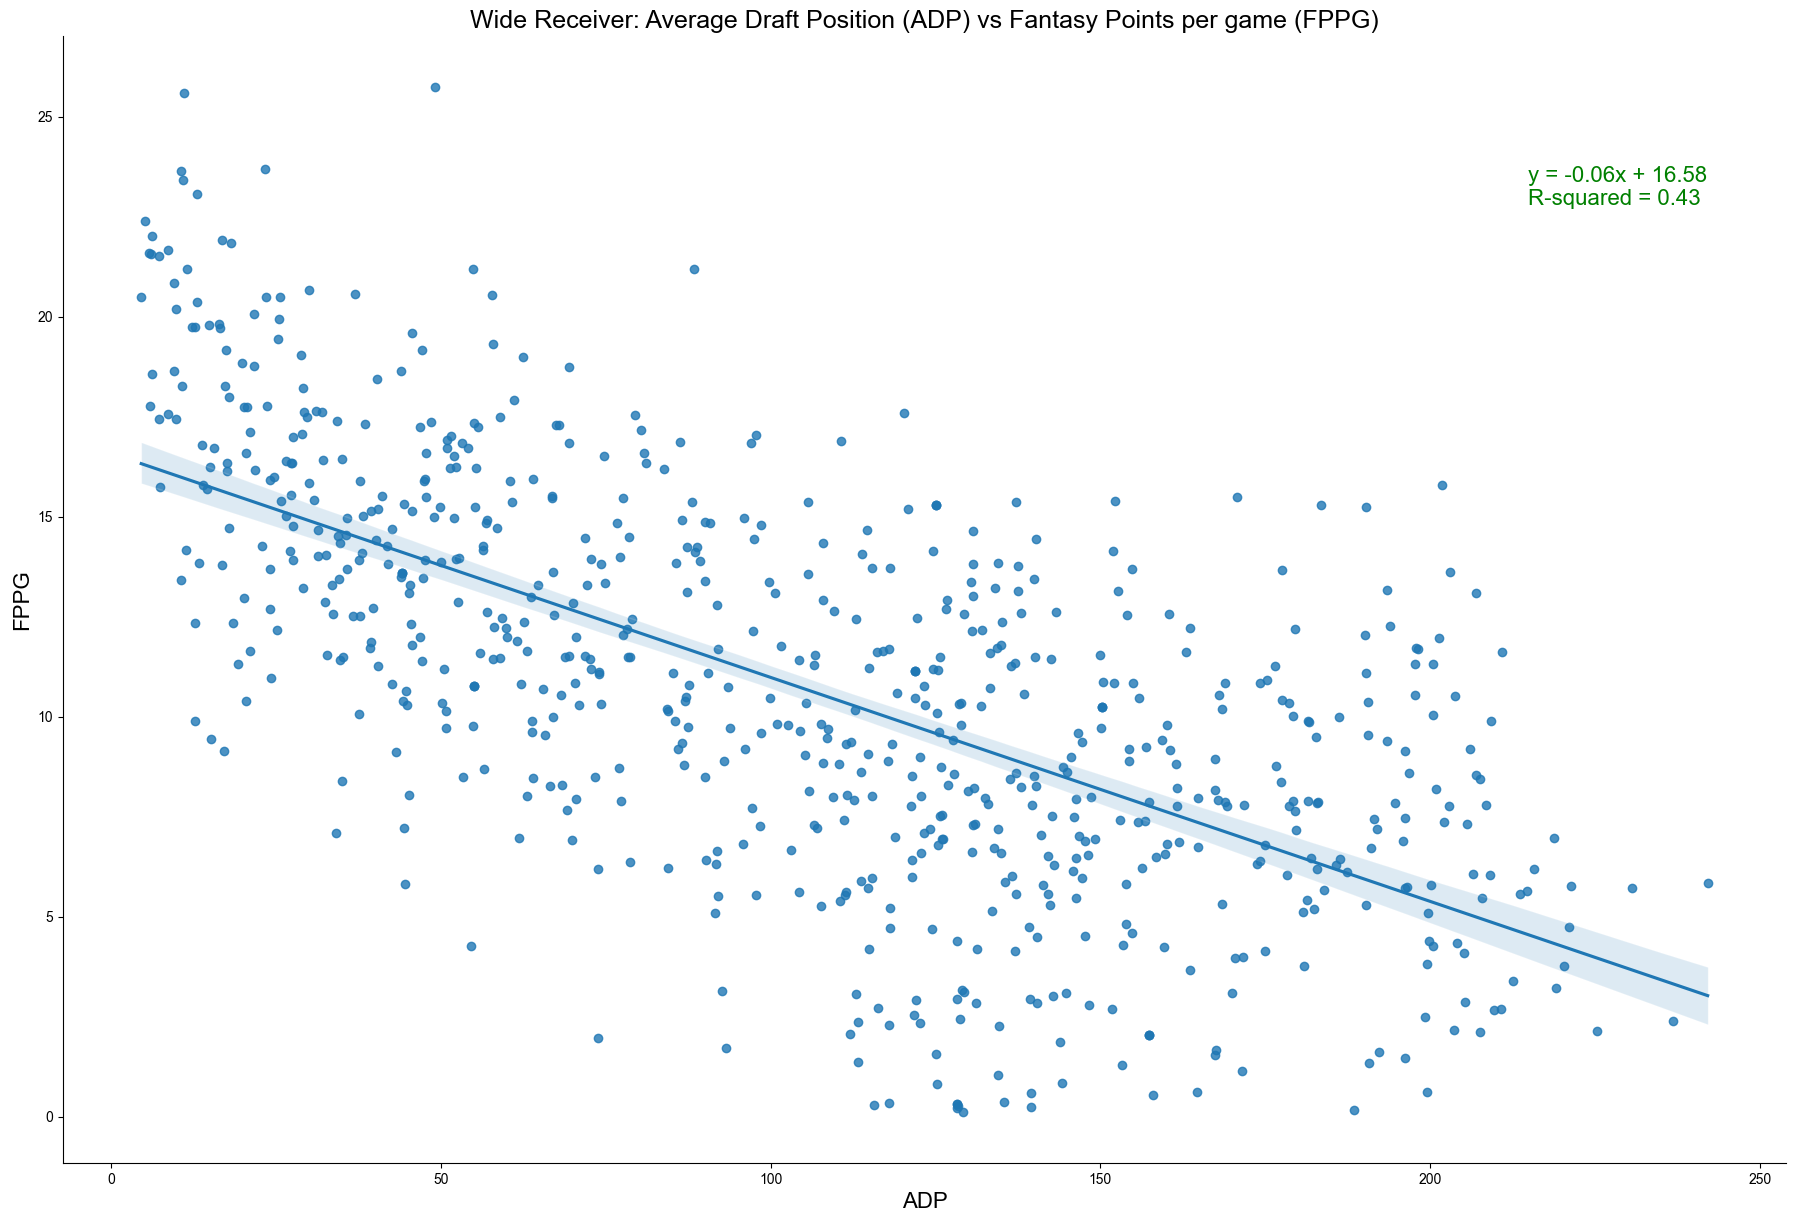

In [15]:
sns.lmplot(x='Avg Pick', y='FPPG', data=wr_analysis_df, height=12, aspect=1.5)
sns.set(style="whitegrid")

slope, intercept, r_value, p_value, std_err = linregress(wr_analysis_df['Avg Pick'], wr_analysis_df['FPPG'])
equation = f'y = {slope:.2f}x + {intercept:.2f}\nR-squared = {r_value**2:.2f}'
plt.annotate(equation, xy=(0.85, 0.85), xycoords='axes fraction', fontsize=16, color='green')

plt.title('Wide Receiver: Average Draft Position (ADP) vs Fantasy Points per game (FPPG)', size = 18)
plt.xlabel('ADP', size = 16)
plt.ylabel('FPPG', size = 16)


# plt.savefig("../results/figures/adp_fppg_eda.png",bbox_inches='tight')
# plt.savefig("../results/figures/adp_fppg_eda_transparent.png", bbox_inches='tight', transparent = True)

In [16]:
wr_analysis_df = wr_analysis_df.rename(columns={"Avg Pick": "ADP", "No.":"pos_no" })

In [17]:
model = smf.ols("FPPG ~  ADP + Round", data = wr_analysis_df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   FPPG   R-squared:                       0.431
Model:                            OLS   Adj. R-squared:                  0.429
Method:                 Least Squares   F-statistic:                     275.0
Date:                Wed, 06 Dec 2023   Prob (F-statistic):           1.15e-89
Time:                        12:05:52   Log-Likelihood:                -2006.7
No. Observations:                 730   AIC:                             4019.
Df Residuals:                     727   BIC:                             4033.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     16.5571      0.340     48.718      0.0

In [18]:
model = smf.ols("FPPG ~  ADP", data = wr_analysis_df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   FPPG   R-squared:                       0.431
Model:                            OLS   Adj. R-squared:                  0.430
Method:                 Least Squares   F-statistic:                     550.8
Date:                Wed, 06 Dec 2023   Prob (F-statistic):           3.93e-91
Time:                        12:05:52   Log-Likelihood:                -2006.7
No. Observations:                 730   AIC:                             4017.
Df Residuals:                     728   BIC:                             4027.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     16.5782      0.286     57.909      0.0

In [19]:
model = smf.ols("FPPG ~  ADP + current_yr", data = wr_analysis_df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   FPPG   R-squared:                       0.446
Model:                            OLS   Adj. R-squared:                  0.444
Method:                 Least Squares   F-statistic:                     292.2
Date:                Wed, 06 Dec 2023   Prob (F-statistic):           7.61e-94
Time:                        12:05:52   Log-Likelihood:                -1997.0
No. Observations:                 730   AIC:                             4000.
Df Residuals:                     727   BIC:                             4014.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     15.4719      0.378     40.969      0.0

In [20]:
model = smf.ols("FPPG ~  ADP + np.power(ADP,2)", data = wr_analysis_df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   FPPG   R-squared:                       0.474
Model:                            OLS   Adj. R-squared:                  0.473
Method:                 Least Squares   F-statistic:                     328.2
Date:                Wed, 06 Dec 2023   Prob (F-statistic):          2.77e-102
Time:                        12:05:52   Log-Likelihood:                -1977.5
No. Observations:                 730   AIC:                             3961.
Df Residuals:                     727   BIC:                             3975.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           19.1246      0.428  

In [21]:
wr_analysis_df['ADP_squared'] = np.power(wr_analysis_df['ADP'], 2)

In [22]:
# applying the model to dataframe to predict FPPG for each row entry/observation
model = smf.ols("FPPG ~ ADP + np.power(ADP, 2)", data = wr_analysis_df).fit()
print(model.summary())
wr_analysis_df_const = sm.add_constant(wr_analysis_df[['ADP', 'ADP_squared']])
wr_analysis_df['Predicted_FPPG'] = model.predict(wr_analysis_df_const)


                            OLS Regression Results                            
Dep. Variable:                   FPPG   R-squared:                       0.474
Model:                            OLS   Adj. R-squared:                  0.473
Method:                 Least Squares   F-statistic:                     328.2
Date:                Wed, 06 Dec 2023   Prob (F-statistic):          2.77e-102
Time:                        12:05:52   Log-Likelihood:                -1977.5
No. Observations:                 730   AIC:                             3961.
Df Residuals:                     727   BIC:                             3975.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           19.1246      0.428  

## Data Visualization

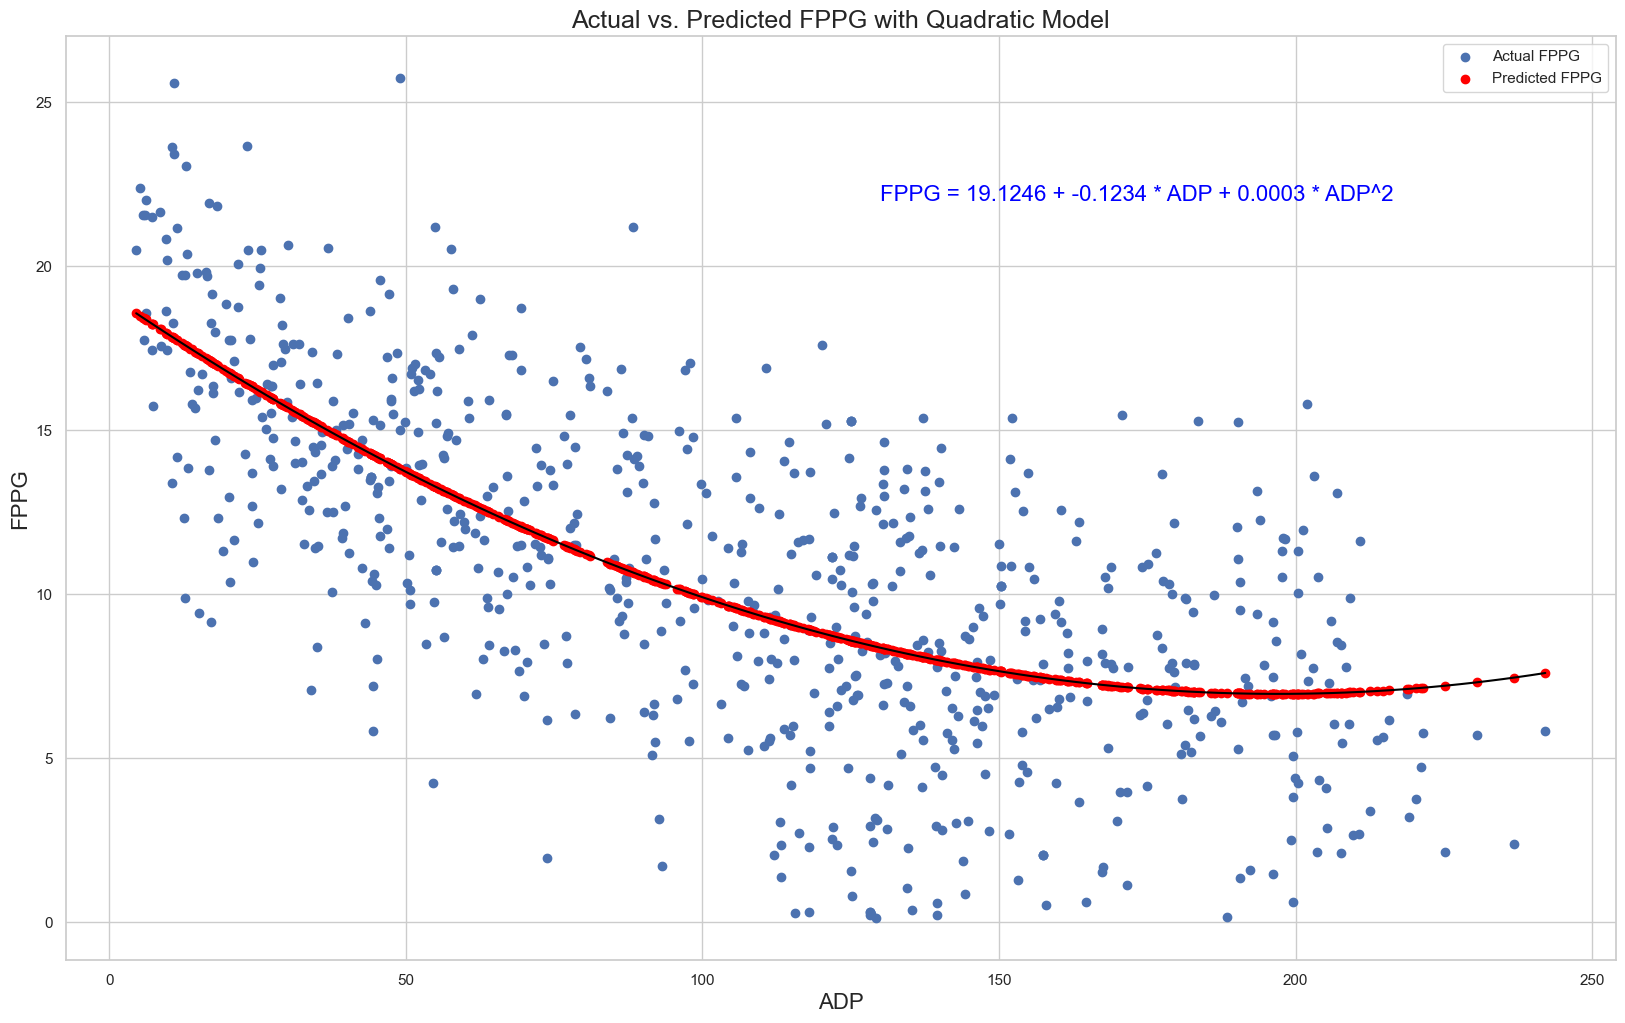

In [23]:
# scatter plot of actual vs. predicted FPPG
plt.figure(figsize=(20, 12))
plt.scatter(wr_analysis_df['ADP'], wr_analysis_df['FPPG'], label='Actual FPPG')
plt.scatter(wr_analysis_df['ADP'], wr_analysis_df['Predicted_FPPG'], label='Predicted FPPG', color='red')
plt.xlabel('ADP', size = 16)
plt.ylabel('FPPG', size = 16)
plt.title('Actual vs. Predicted FPPG with Quadratic Model', size = 18)
plt.legend()

adp_values = np.linspace(wr_analysis_df['ADP'].min(), wr_analysis_df['ADP'].max(), 100)
predicted_values = model.predict(sm.add_constant(pd.DataFrame({'ADP': adp_values, 'ADP_squared': np.power(adp_values, 2)})))
plt.plot(adp_values, predicted_values, label='Quadratic Model', color='black')
equation = f"FPPG = {model.params['Intercept']:.4f} + {model.params['ADP']:.4f} * ADP + {model.params['np.power(ADP, 2)']:.4f} * ADP^2"
plt.text(130,22, equation, color='blue', fontsize = 16)

# plt.savefig("../results/figures/ols_quadratic_model.png", bbox_inches='tight')
# plt.savefig("../results/figures/ols_quadratic_model_transparent.png", bbox_inches='tight', transparent = True)
plt.show()

## Application of Analysis and Data Visualizations

In [24]:
r_mid_wr = wr_analysis_df[(wr_analysis_df['ADP'] >= 60) & (wr_analysis_df['ADP'] <= 108)]
r_mid_wr['diff_fppg'] = wr_analysis_df['FPPG'] - wr_analysis_df['Predicted_FPPG']

Text(0, 0.5, 'Diff. FPPG relative to ADP')

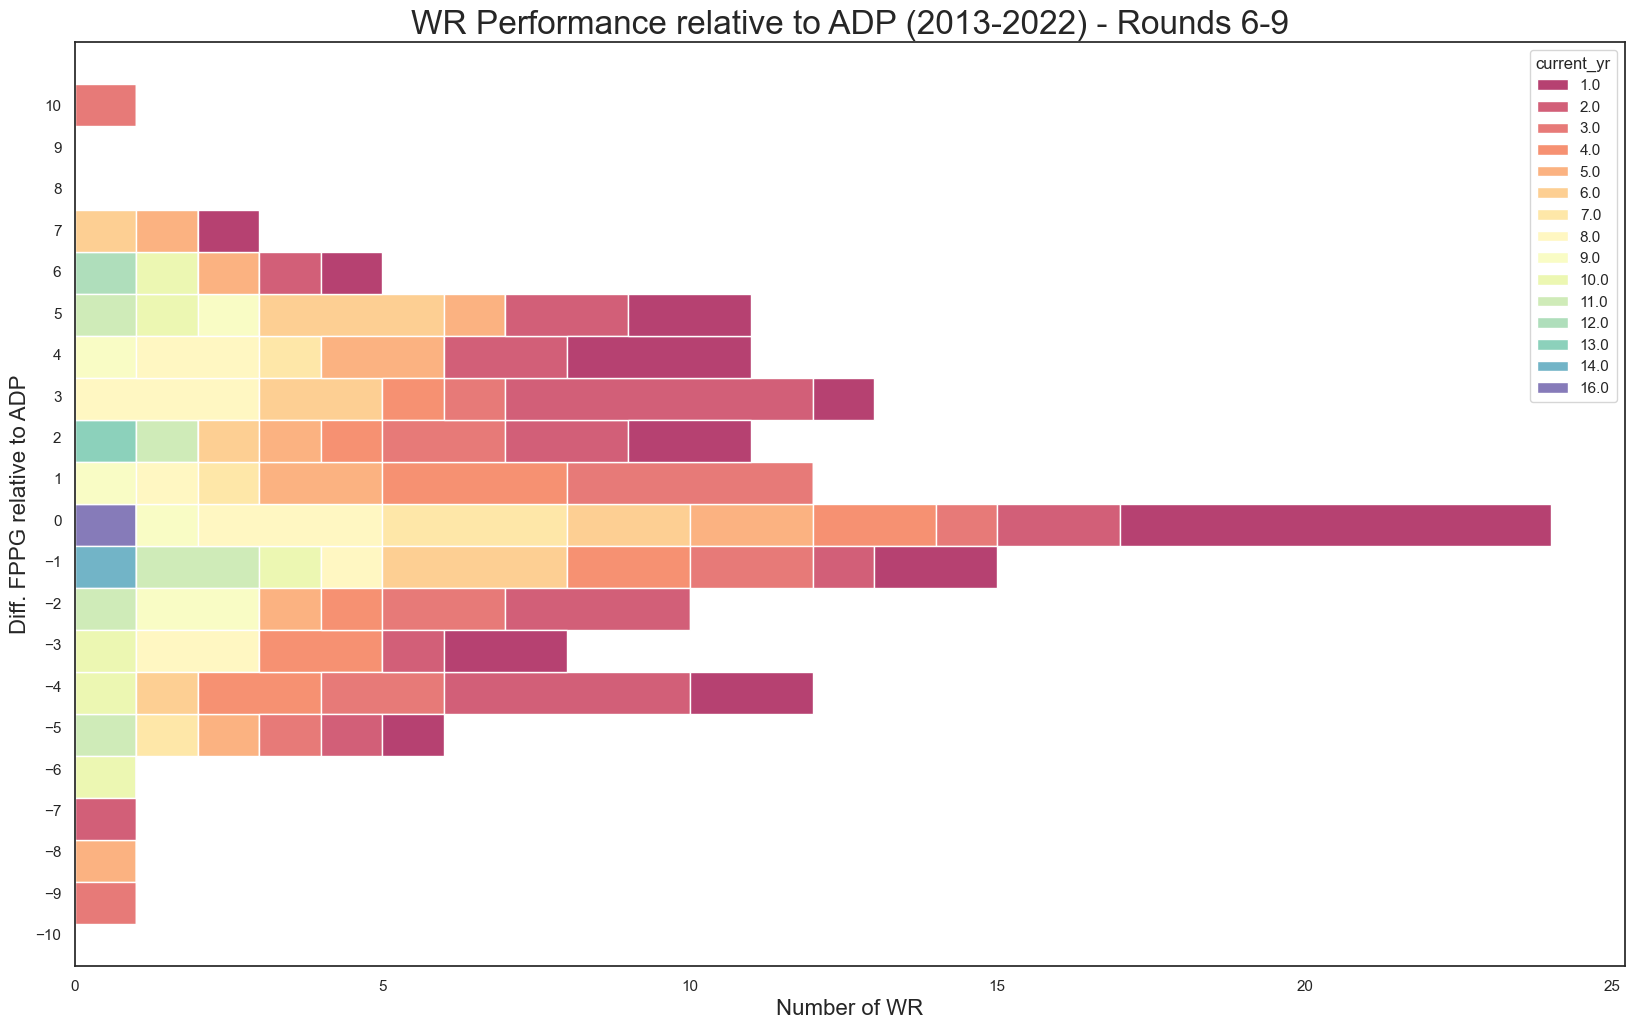

In [25]:
sns.set(style='white')
plt.figure(figsize=(20, 12))
sns.histplot(data = r_mid_wr, y='diff_fppg', hue='current_yr', multiple = 'stack',binwidth=1, palette='Spectral', bins = 'integer')
plt.title('WR Performance relative to ADP (2013-2022) - Rounds 6-9', size = 24)
plt.xlabel('Number of WR', size = 16)
plt.yticks(np.arange(-10, 11, step = 1))
plt.ylabel('Diff. FPPG relative to ADP', size = 16)

# plt.savefig("../results/figures/wr_relative_adp.png", bbox_inches='tight')


In [26]:
bo_wr_analysis_df = r_mid_wr.loc[(r_mid_wr.diff_fppg >= 3),:]
bo_wr_analysis_df.shape

(39, 33)

Text(0, 0.5, '# of WRs')

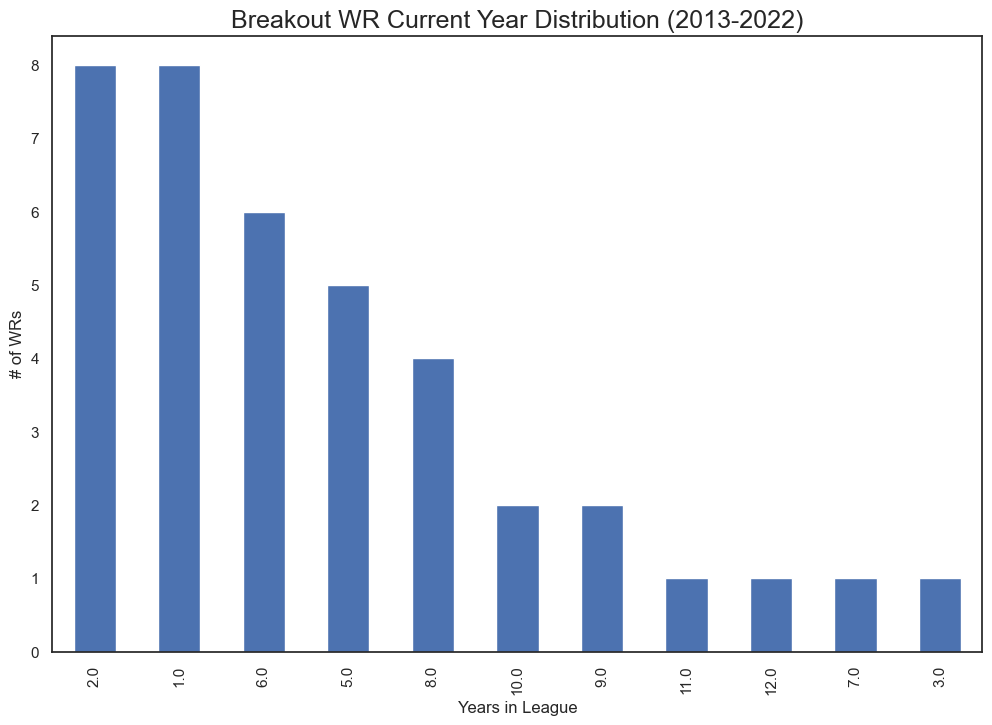

In [27]:
plt.figure(figsize=(12, 8))
bo_wr_analysis_df.current_yr.value_counts().plot(kind='bar')
plt.title("Breakout WR Current Year Distribution (2013-2022)", size = 18)
plt.xlabel("Years in League", size = 12)
plt.ylabel("# of WRs",size = 12)

# plt.savefig("../results/figures/bo_wr_current_yr_distribution.png", bbox_inches='tight')

Text(0, 0.5, '# of WRs')

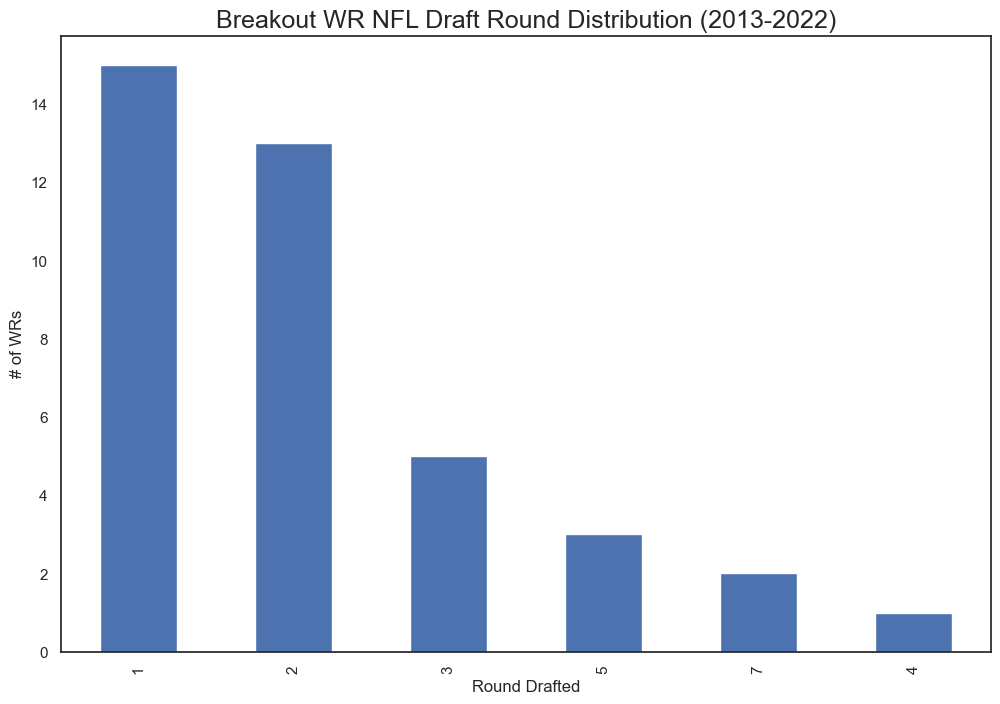

In [28]:
plt.figure(figsize=(12, 8))
bo_wr_analysis_df.Round.value_counts().plot(kind='bar')
plt.title("Breakout WR NFL Draft Round Distribution (2013-2022)", size = 18)
plt.xlabel("Round Drafted", size = 12)
plt.ylabel("# of WRs",size = 12)

# plt.savefig("../results/figures/bo_wr_draft_round_distribution.png", bbox_inches='tight')

In [29]:
wr_2023 = pd.read_csv("../data/analysis_df/2023_adp.csv")
wr_2023 = wr_2023.rename(columns={"Avg Pick": "ADP"})
wr_2023 = wr_2023[(wr_2023['ADP'] >= 60) & (wr_2023['ADP'] <= 108)]
wr_2023.shape

(25, 12)

In [33]:
# potential breakout wide receivers for the 2023-2024 fantasy football season
wr_2023.loc[(wr_2023['current_yr'].isin([1, 2, 6])) & (wr_2023['Round'] <= 2), :]

,Rank,Player,ADP,Pos,Tm,Season,rookie_season,No.,Round,Pick,College,current_yr
25,61,Christian Kirk,62.19,WR,JAC,2023,2018.0,5,2,15,Texas A&M,6.0
29,72,George Pickens,71.21,WR,PIT,2023,2022.0,11,2,20,Georgia,2.0
30,76,Jordan Addison,73.18,WR,MIN,2023,2023.0,4,1,23,USC,1.0
32,81,Jaxon Smith-Njigba,78.69,WR,SEA,2023,2023.0,1,1,20,Ohio State,1.0
33,82,Jahan Dotson,78.96,WR,WAS,2023,2022.0,5,1,16,Penn State,2.0
34,83,Zay Flowers,79.60,WR,BAL,2023,2023.0,3,1,22,Boston College,1.0
36,89,Courtland Sutton,83.90,WR,DEN,2023,2018.0,3,2,8,Southern Methodist,6.0
40,108,Quentin Johnston,98.65,WR,LAC,2023,2023.0,2,1,21,Texas Christian,1.0
44,128,Skyy Moore,105.96,WR,KCC,2023,2022.0,13,2,22,Western Michigan,2.0
